## ThinkDSP

This notebook contains solutions to exercises in Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [22]:
# Get thinkdsp.py

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Exercise 1

In this chapter I claim that `analyze1` takes time proportional
to $n^3$ and `analyze2` takes time proportional to $n^2$.  To
see if that's true, run them on a range of input sizes and time
them.  In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you
should get a straight line with slope 3 for  `analyze1` and
slope 2 for `analyze2`.  You also might want to test `dct_iv`
and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [24]:
from thinkdsp import UncorrelatedUniformNoise

signal = UncorrelatedUniformNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [25]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [26]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Works for the general case where M is not orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [27]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

Here are the results for `analyze1`.

In [28]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096], dtype=int32)

64
103 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
374 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.87 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
7.58 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
38 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
190 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
927 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.20466820672786

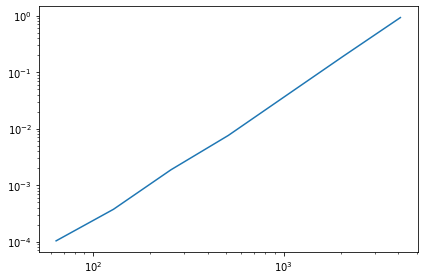

In [29]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

The estimated slope is close to 2, not 3, as expected.  One possibility is that the performance of `np.linalg.solve` is nearly quadratic in this range of array sizes.

Here are the results for `analyze2`:

In [30]:
def analyze2(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Assumes that fs and ts are chosen so that M is orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
59.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
202 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
757 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
4.15 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
18.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
68.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
276 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.0699194763495856

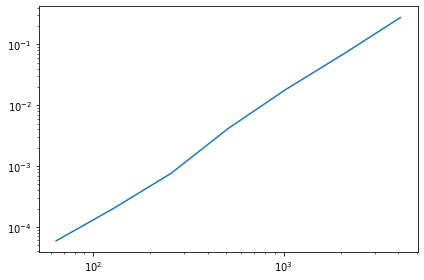

In [31]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

The results for `analyze2` fall in a straight line with the estimated slope close to 2, as expected.

Here are the results for the `scipy.fftpack.dct`

In [32]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
8.19 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
8.62 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
10.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
11.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
14.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
23.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
42.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.373670068553703

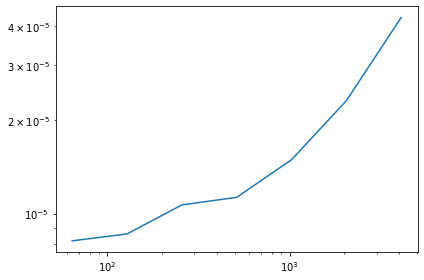

In [33]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

This implementation of dct is even faster.  The line is curved, which means either we haven't seen the asymptotic behavior yet, or the asymptotic behavior is not a simple exponent of $n$.  In fact, as we'll see soon, the run time is proportional to $n \log n$.

The following figure shows all three curves on the same axes.

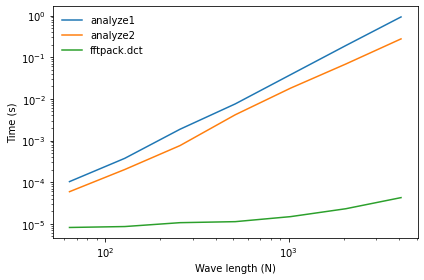

In [34]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

## Exercise 2

One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [64]:
from thinkdsp import read_wave

wave = read_wave('Sounds/352544__venjix__nino.wav')
wave.make_audio()

Here's a short segment:

In [65]:
segment = wave.segment(start=5, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

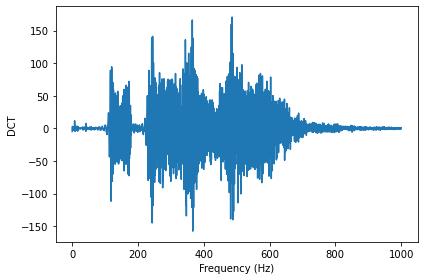

In [75]:
seg_dct = segment.make_dct()
seg_dct.plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

There are only a few harmonics with substantial amplitude, and many entries near zero.

The following function takes a DCT and sets elements below `thresh` to 0.

In [67]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

If we apply it to the segment, we can eliminate more than 90% of the elements:

3057	4000	76.425


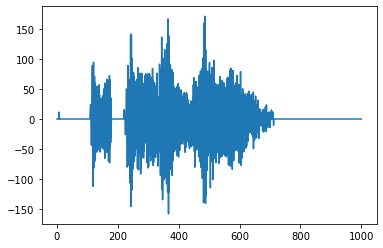

In [76]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=1000)

And the result sounds the same (at least to me):

In [69]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

To compress a longer segment, we can make a DCT spectrogram.  The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [70]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Now we can make a DCT spectrogram and apply `compress` to each segment:

In [104]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.1)

1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1023	1024	99.90234375
1023	1024	99.90234375
1020	1024	99.609375
1012	1024	98.828125
1014	1024	99.0234375
1017	1024	99.31640625
1010	1024	98.6328125
1006	1024	98.2421875
1013	1024	98.92578125
1022	1024	99.8046875
110	1024	10.7421875
99	1024	9.66796875
188	1024	18.359375
134	1024	13.0859375
74	1024	7.2265625
86	1024	8.3984375
172	1024	16.796875
291	1024	28.41796875
501	1024	48.92578125
805	1024	78.61328125
966	1024	94.3359375
991	1024	96.77734375
1022	1024	99.8046875
1019	1024	99.51171875
899	1024	87.79296875
937	1024	91.50390625
1005	1024	98.14453125
1014	1024	99.0234375
1006	1024	98.2421875
585	1024	57.12890625
261	1024	25.48828125
311	1024	30.37109375
384	1024	37.5
226	1024	22.0703125
120	1024	11.71875
216	1024	21.09375
525	1024	51.26953125
916	1024	89.453125
967	1024	94.43359375
991	1024	96.77734375
1015	1024	99.12109375
1023	1024	99.90234375
1024	1024	100.0
943	1024	92.08984375
990	1024	96.6796875
969	10

In most segments, the compression is 75-85%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [105]:
wave2 = spectro.make_wave()
wave2.make_audio()

And here's the original again for comparison.

In [106]:
wave.make_audio()

As an experiment, you might try increasing `thresh` to see when the effect of compression becomes audible (to you).

Also, you might try compressing a signal with some noisy elements, like cymbals.